## Domain knowledge discretisation

Frequently, when engineering variables in a business setting, the business experts determine the intervals in which they think the variable should be divided so that it makes sense for the business. These intervals may be defined both arbitrarily or following some criteria of use to the business. Typical examples are the discretisation of variables like Age and Income. 

Income for example is usually capped at a certain maximum value, and all incomes above that value fall into the last bucket. As per Age, it is usually divided in certain groups according to the business need, for example division into  0-21 (for under-aged), 20-30 (for young adults), 30-40, 40-60, and > 60 (for retired or close to) are frequent.

Below I will show how this seemingly straightforward method works.

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline


In [2]:
# load the numerical variables of the Titanic Dataset
data = pd.read_csv('titanic.csv', usecols = ['Age', 'Survived'])
data.head()

,Survived,Age
0,0,22.0
1,1,38.0
2,1,26.0
3,1,35.0
4,0,35.0


The variable Age contains missing data, that I will fill by extracting a random sample of the variable.

In [3]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    
    # extract the random sample to fill the na
    random_sample = data[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [4]:
# let's fill the missing data
data['Age'] = impute_na(data, 'Age')

### Age
### Original distribution

In [5]:
data.Age.describe()

count    891.000000
mean      29.700348
std       14.563654
min        0.420000
25%       21.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [6]:
# let's divide Age into the buckets that we described in the intro cell

# bucket boundaries
buckets = [0,20,40,60,1000]

# bucket labels
labels = ['0-20', '20-40', '40-60', '>60']

# discretisation
data['Age_buckets_labels'] = pd.cut(data.Age, bins=buckets, labels = labels, include_lowest=True)
data['Age_buckets'] = pd.cut(data.Age, bins=buckets, include_lowest=True)

data.head()

,Survived,Age,Age_buckets_labels,Age_buckets
0,0,22.0,20-40,"(20.0, 40.0]"
1,1,38.0,20-40,"(20.0, 40.0]"
2,1,26.0,20-40,"(20.0, 40.0]"
3,1,35.0,20-40,"(20.0, 40.0]"
4,0,35.0,20-40,"(20.0, 40.0]"


In [7]:
data.tail()

,Survived,Age,Age_buckets_labels,Age_buckets
886,0,27.0,20-40,"(20.0, 40.0]"
887,1,19.0,0-20,"(-0.001, 20.0]"
888,0,15.0,0-20,"(-0.001, 20.0]"
889,1,26.0,20-40,"(20.0, 40.0]"
890,0,32.0,20-40,"(20.0, 40.0]"


Above we can observe the buckets into which each Age observation was placed. For example, age 27 was placed into the 20-40 bucket.

Let's explore the number of observations and survival rate per bucket after this arbitrary discretisation method.

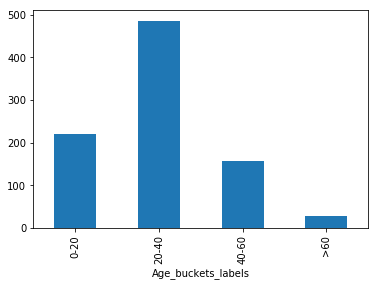

In [8]:
# number of passengers per age bucket
data.groupby('Age_buckets_labels')['Age'].count().plot.bar()

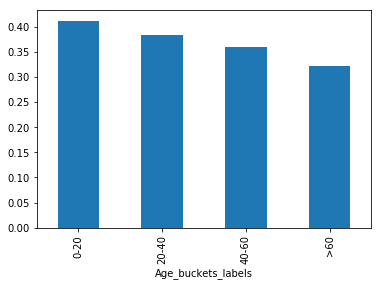

In [9]:
# survival rate per age bucket
data.groupby('Age_buckets_labels')['Survived'].mean().plot.bar()

The majority of people on the Titanic were between 20-40 years of age. We can see that all the age bins have the same Survival rate. Therefore, most likely, this is not a good method of grouping the Age variable to improve model predictive performance.

**So when would we use a discretisation method like this?**

Well for example, if the business was organising marketing campaigns, and they decide that they will run 4 different marketing campaigns each one targeting each of this buckets, then, dividing age into these groups makes sense for further analysis.

### Lending Club

Let's explore discretisation using domain knowledge in a different business scenario. I will use the loan book from the peer to peer lending company Lending Club. This dataset contains information on loans given to people, and the financial characteristics of those people as well as the loan performance.

In [10]:
# I will load only the income declared by the borrower for the demonstration

data = pd.read_csv('loan.csv', usecols=['annual_inc'])
data.head()

,annual_inc
0,24000.0
1,30000.0
2,12252.0
3,49200.0
4,80000.0


In [11]:
data.annual_inc.describe()

count    8.873750e+05
mean     7.502759e+04
std      6.469830e+04
min      0.000000e+00
25%      4.500000e+04
50%      6.500000e+04
75%      9.000000e+04
max      9.500000e+06
Name: annual_inc, dtype: float64

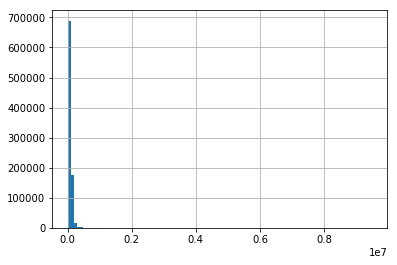

In [12]:
# let's inspect the distribution of Incomes
data.annual_inc.hist(bins=100)

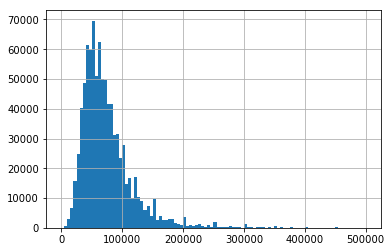

In [13]:
# and now let's look at the lower incomes in more detail
data[data.annual_inc<500000].annual_inc.hist(bins=100)

We can see that the majority of the population earns below 150,000. So we may want to make a cap there.

In [14]:
data[data.annual_inc<500000].describe()

,annual_inc
count,886115.000000
mean,73900.859540
std,43818.534502
min,0.000000
25%,45000.000000
50%,64609.000000
75%,90000.000000
max,499992.000000


In [15]:
# and now let's divide into arbitrary buckets, assuming that these make business sense

# bucket interval
buckets = [0,45000,65000,90000,150000,1e10]

# bucket labels
labels = ['0-45k', '45-65k', '65-90k','90-150k', '>150k']

# discretisation
data['Income_buckets'] = pd.cut(data.annual_inc, bins=buckets, labels = labels, include_lowest=True)
data.head()

,annual_inc,Income_buckets
0,24000.0,0-45k
1,30000.0,0-45k
2,12252.0,0-45k
3,49200.0,45-65k
4,80000.0,65-90k


In [16]:
data.tail()

,annual_inc,Income_buckets
887374,31000.0,0-45k
887375,79000.0,65-90k
887376,35000.0,0-45k
887377,64400.0,45-65k
887378,100000.0,90-150k


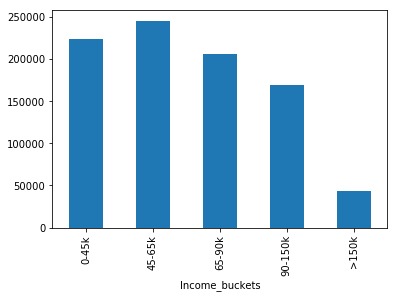

In [17]:
data.groupby(['Income_buckets'])['annual_inc'].count().plot.bar()

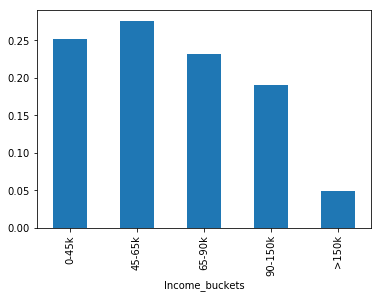

In [18]:
(data.groupby(['Income_buckets'])['annual_inc'].count()/np.float(len(data))).plot.bar()

We  have captured ~equal amount of borrowers in each of the first 3 buckets, and we see clearly, that a smaller percentage of the loans were disbursed to high earners.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**